# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
## 超參數設定
LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 30
BATCH_SIZE = 256
MOMENTUM = 0.95



### SGD

In [7]:
results = {}
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    #model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0720 03:31:29.659336 140258745325440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0720 03:31:29.661083 140258745325440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0720 03:31:29.706277 140258745325440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 03:31:29.711442 140258745325440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W072

Experiment with LR = 0.100000


W0720 03:31:29.948985 140258745325440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 6s 120us/step - loss: 2.0555 - acc: 0.2422 - val_loss: 1.9086 - val_acc: 0.2900
Epoch 2/30
50000/50000 [==============================] - 2s 48us/step - loss: 1.8469 - acc: 0.3212 - val_loss: 1.8260 - val_acc: 0.3374
Epoch 3/30
50000/50000 [==============================] - 2s 48us/step - loss: 1.7594 - acc: 0.3624 - val_loss: 2.0250 - val_acc: 0.2992
Epoch 4/30
50000/50000 [==============================] - 2s 48us/step - loss: 1.7187 - acc: 0.3854 - val_loss: 1.7707 - val_acc: 0.3765
Epoch 5/30
50000/50000 [==============================] - 2s 48us/step - loss: 1.6788 - acc: 0.3990 - val_loss: 1.7728 - val_acc: 0.3677
Epoch 6/30
50000/50000 [==============================] - 2s 48us/step - loss: 1.6612 - acc: 0.4060 - val_loss: 1.6772 - val_acc: 0.3982
Epoch 7/30
50000/50000 [==============================] - 2s 48us/step - loss: 1.6424 - acc: 0.4139 - val_loss: 1.7109 - val_ac

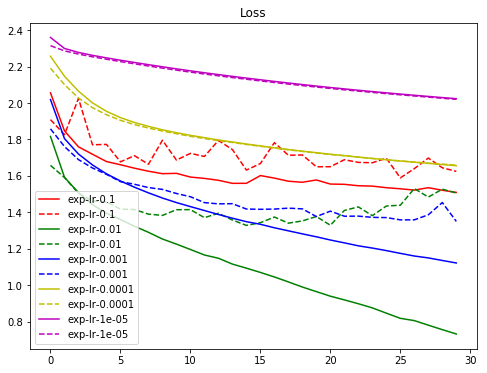

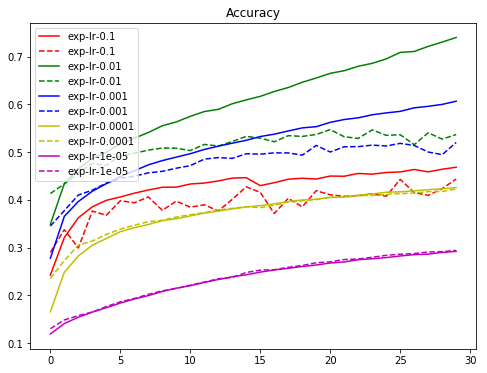

In [8]:
import matplotlib.pyplot as plt
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### RMSprop

In [10]:
results = {}
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    #model.summary()
    optimizer = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.100000
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 3s 65us/step - loss: 14.4445 - acc: 0.1001 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/30
50000/50000 [==============================] - 3s 60us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/30
50000/50000 [==============================] - 3s 60us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/30
50000/50000 [==============================] - 3s 64us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/30
50000/50000 [==============================] - 3s 64us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/30
50000/50000 [==============================] - 3s 63us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/30
50000/50000 [==============================] - 3s 62us/step - loss: 14.5063

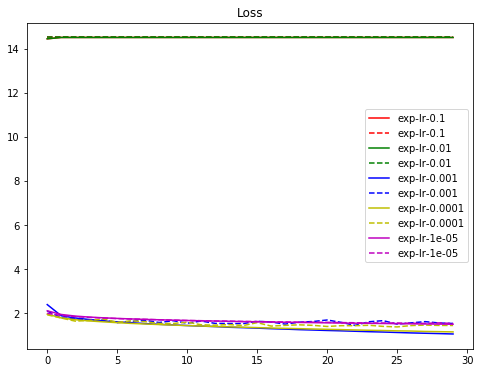

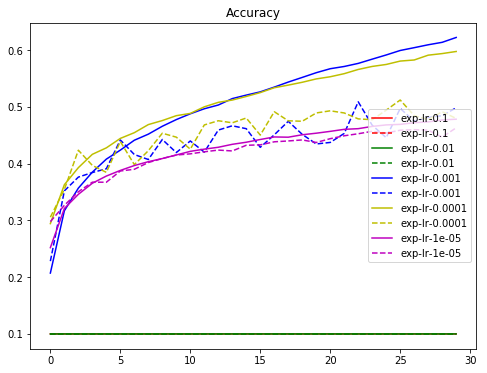

In [11]:
import matplotlib.pyplot as plt
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### Adagrad

In [13]:

results = {}
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    #model.summary()
    optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.001)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.100000
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 3s 51us/step - loss: 14.4457 - acc: 0.0999 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/30
50000/50000 [==============================] - 2s 47us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/30
50000/50000 [==============================] - 2s 47us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/30
50000/50000 [==============================] - 2s 47us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/30
50000/50000 [==============================] - 2s 45us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/30
50000/50000 [==============================] - 2s 46us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/30
50000/50000 [==============================] - 3s 50us/step - loss: 14.5063

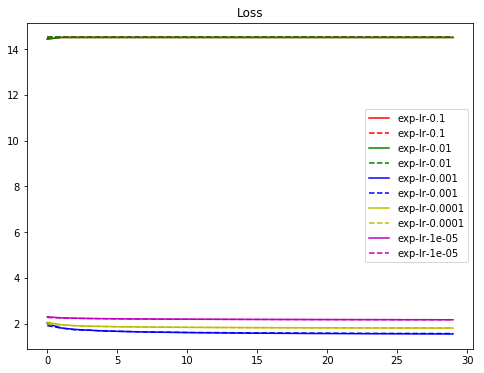

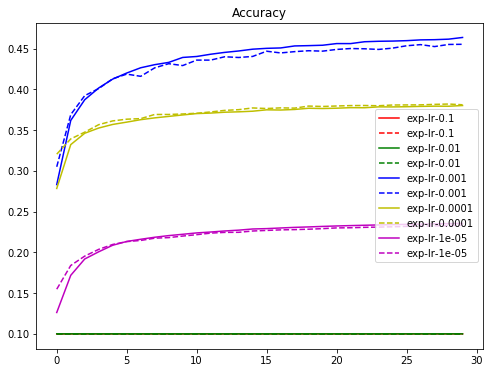

In [14]:
import matplotlib.pyplot as plt
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### Adam

In [9]:
results = {}
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    #model.summary()
    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=False)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.100000
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 6s 112us/step - loss: 14.4480 - acc: 0.0998 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/30
50000/50000 [==============================] - 5s 101us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/30
50000/50000 [==============================] - 5s 96us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/30
50000/50000 [==============================] - 5s 93us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/30
50000/50000 [==============================] - 5s 93us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/30
50000/50000 [==============================] - 5s 93us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/30
50000/50000 [==============================] - 5s 93us/step - loss: 14.50

50000/50000 [==============================] - 5s 95us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 29/30
50000/50000 [==============================] - 5s 95us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 30/30
50000/50000 [==============================] - 5s 95us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Experiment with LR = 0.001000
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 6s 110us/step - loss: 1.9164 - acc: 0.3090 - val_loss: 1.7643 - val_acc: 0.3710
Epoch 2/30
50000/50000 [==============================] - 5s 95us/step - loss: 1.6998 - acc: 0.3919 - val_loss: 1.6868 - val_acc: 0.3949
Epoch 3/30
50000/50000 [==============================] - 5s 96us/step - loss: 1.6112 - acc: 0.4235 - val_loss: 1.5899 - val_acc: 0.4338
Epoch 4/30
50000/50000 [==============================] - 5s 99us/step - loss: 1.5412 - acc: 0.4505 

50000/50000 [==============================] - 6s 113us/step - loss: 1.2884 - acc: 0.5529 - val_loss: 1.3822 - val_acc: 0.5113
Epoch 27/30
50000/50000 [==============================] - 5s 105us/step - loss: 1.2828 - acc: 0.5550 - val_loss: 1.3797 - val_acc: 0.5123
Epoch 28/30
50000/50000 [==============================] - 6s 115us/step - loss: 1.2774 - acc: 0.5567 - val_loss: 1.3772 - val_acc: 0.5131
Epoch 29/30
50000/50000 [==============================] - 5s 92us/step - loss: 1.2721 - acc: 0.5584 - val_loss: 1.3747 - val_acc: 0.5138
Epoch 30/30
50000/50000 [==============================] - 5s 90us/step - loss: 1.2671 - acc: 0.5607 - val_loss: 1.3725 - val_acc: 0.5146
Experiment with LR = 0.000010
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 5s 109us/step - loss: 2.1289 - acc: 0.2390 - val_loss: 2.0065 - val_acc: 0.2935
Epoch 2/30
50000/50000 [==============================] - 4s 90us/step - loss: 1.9489 - acc: 0.3215 -

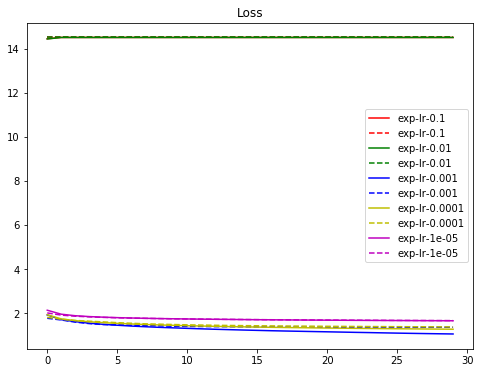

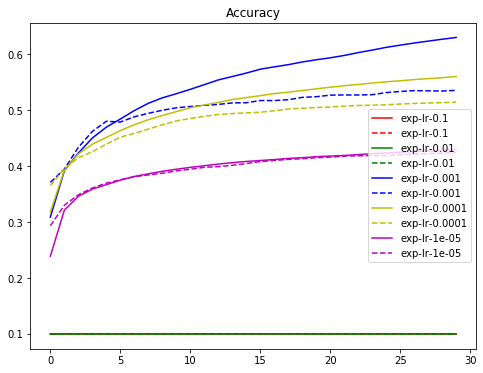

In [11]:
import matplotlib.pyplot as plt
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()